In [1]:
import numpy as np
import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # for tstamps
from pathlib import Path
plt.rcParams['mathtext.default'] = 'regular'

In [2]:
# Choose experiment
exp = 'xojnb'
path_to_ukca = Path(f'../data/{exp}')
# Load data
o3 = iris.load_cube(str(path_to_ukca / f'{exp}_check.pp'), 'mass_fraction_of_ozone_in_air') # [kg kg-1]
oh = iris.load_cube(str(path_to_ukca / f'{exp}_check.pp'), 'mass_fraction_of_hydroxyl_radical_in_air') # [kg kg-1]
ch4 = iris.load_cube(str(path_to_ukca / f'{exp}_check.pp'), 'mass_fraction_of_methane_in_air') # [kg kg-1]
temp = iris.load_cube(str(path_to_ukca / f'{exp}_check.pp'), 'air_temperature') # [K]
air_mass = iris.load_cube(str(path_to_ukca / f'{exp}_check.pp'), iris.AttributeConstraint(STASH='m01s34i363')) # air mass [kg]
trop_mask = iris.load_cube(str(path_to_ukca / f'{exp}_check.pp'), iris.AttributeConstraint(STASH='m01s34i362')) # tropospheric mask fraction [no units]
gridbox_vol = iris.load_cube(str(path_to_ukca.parent / 'ukca_n48_l60_geovol.nc'), 'vol_theta') # UKCA grid box volume [m3]
# Path to figures
path_to_figs = Path('../../../results') / exp / 'metrics'
path_to_figs.mkdir(exist_ok=True)

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/fileformats/rules.py:334: UserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(msg.format(factory=factory_name))
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 't' invalid units 'months since 0000-00-00 00:00:00 +00:00'
  warnings.warn(msg)
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 't' invalid units 'months since 0000-00-00 00:00:00 +00:00'
  warnings.warn(msg)
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 't' invalid units 'months since 0000-00-00 00:00:00 +00:00'
  warnings.warn(msg)


In [3]:
# Specify variable units using info from the documentation
air_mass.units = 'kg'
trop_mask.units = '1'
gridbox_vol.units = 'm3'
# Check if Dec is the first month
cb = o3.copy()
n_yrs = int(cb.coord('time').points.shape[0]/12) # count number of years, year starts from Dec!
iris.coord_categorisation.add_year(cb, 'time', name='year')
iris.coord_categorisation.add_month(cb, 'time', name='month')
cb.coord('month')

AuxCoord(array(['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
       'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
       'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
       'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov'], dtype='<U64'), standard_name=None, units=Unit('no_un

In [8]:
# Create datetime coordinate for plotting
tstamp0 = datetime.datetime.strptime(f"{cb.coord('year').points[0]} "+cb.coord('month').points[0], "%Y %b")
tstamp1 = datetime.datetime.strptime(f"{cb.coord('year').points[-1]} "+cb.coord('month').points[-1], "%Y %b")
tstamps = pd.date_range(tstamp0, tstamp1, freq='MS')

#### Chose definition of the troposphere

In [ ]:
trop_def = 'chemical'

In [13]:
if trop_def == 'diagnostic':
    # Use tropospheric mask variable
    trop_mask = trop_mask
if trop_def == 'chemical':
    # Define chemical troposphere as one where O3 is less than 125 ppb
    molar_mass_air = iris.coords.AuxCoord(28.9644, units='g mol-1')
    molar_mass_o3 = iris.coords.AuxCoord(47.9982, units='g mol-1')
    coeff_o3 = molar_mass_air.points[0]/molar_mass_o3.points[0]*1e9
    trop_mask = np.ma.masked_less(o3.data*coeff_o3, 125).mask

#### Tropospheric O3 burden

In [14]:
# Calculate O3 burden per month
o3_burden = (o3*air_mass*trop_mask).collapsed(['latitude', 'longitude', 'level_height'], iris.analysis.SUM)
o3_burden.convert_units('Tg')
# Calculate annual mean O3 burden
o3_burden_annual_mean = o3_burden.data.reshape(n_yrs,12).mean(axis=1)
print(f'{np.mean(o3_burden_annual_mean.data):1.2f}\u00B1{np.std(o3_burden_annual_mean.data):1.2f} Tg')

274.54±2.17 Tg


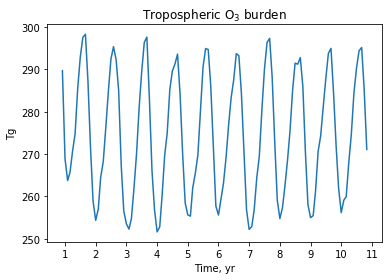

In [15]:
fig, ax = plt.subplots()
ax.plot(tstamps, o3_burden.data)
ax.set_title('Tropospheric $O_3$ burden')
ax.set_xlabel('Time, yr')
ax.set_ylabel('Tg')
# Format xticklabels
plt.draw() # force ticklabels to be generated
new_labels = [int(i.get_text())-cb.coord('year').points[0] for i in ax.get_xticklabels(which='both')]
ax.set_xticklabels(new_labels);
fig.savefig(path_to_figs / f'{exp}_o3_burden.png')

#### Tropospheric CH4 burden

In [16]:
# Calculate CH4 burden per month
ch4_burden = (ch4*air_mass*trop_mask).collapsed(['latitude', 'longitude', 'level_height'], iris.analysis.SUM)
ch4_burden.convert_units('Tg')
# Calculate annual mean CH4 burden
ch4_burden_annual_mean = ch4_burden.data.reshape(n_yrs,12).mean(axis=1)
print(f'{np.mean(ch4_burden_annual_mean.data):1.2f}\u00B1{np.std(ch4_burden_annual_mean.data):1.2f} Tg')

4305.80±96.67 Tg


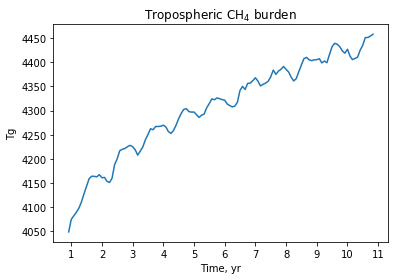

In [17]:
fig, ax = plt.subplots()
ax.plot(tstamps, ch4_burden.data);
ax.set_title('Tropospheric $CH_4$ burden')
ax.set_xlabel('Time, yr')
ax.set_ylabel('Tg')
# Format xticklabels
plt.draw() # force ticklabels to be generated
new_labels = [int(i.get_text())-cb.coord('year').points[0] for i in ax.get_xticklabels(which='both')]
ax.set_xticklabels(new_labels);
fig.savefig(path_to_figs / f'{exp}_ch4_burden.png')

#### CH4 lifetime

In [18]:
# Constants
k_ch4_oh = temp.copy(data=1.85e-12*np.exp(-1690/temp.data))
k_ch4_oh.rename('CH4+OH reaction rate coefficient')
k_ch4_oh.units='cm3 s-1'
molar_mass_oh = iris.coords.AuxCoord(17.007, units='g mol-1')
molar_mass_ch4 = iris.coords.AuxCoord(16.0425, units='g mol-1')
avogadro_number = iris.coords.AuxCoord(6.022*1e23, units='mol-1', long_name='avogadro_number')

In [19]:
# Find number of OH and CH4 molecules per grid box in the troposphere (tropospheric burden in molecules, not kg)
oh_molecules_per_gridbox = oh * air_mass * trop_mask / molar_mass_oh * avogadro_number
ch4_molecules_per_gridbox = ch4 * air_mass * trop_mask / molar_mass_ch4 * avogadro_number

In [20]:
## Prepare gridbox_vol cube for later multiplication by oh_molecules_per_gridbox cube
# Get rid of time coordinate
gridbox_vol = iris.util.squeeze(gridbox_vol) 
gridbox_vol.remove_coord('t')
# Copy oh_molecules_per_gridbox metadata to gridbox_vol cube
_var_name, _units = gridbox_vol.var_name, gridbox_vol.units
gridbox_vol = oh_molecules_per_gridbox[0, ...].copy(data=gridbox_vol.data)
gridbox_vol.rename(_var_name)
gridbox_vol.units = _units
gridbox_vol.remove_coord('forecast_reference_time')

In [21]:
# Calculate CH4 loss in molecules s-1
loss_ch4_oh = k_ch4_oh * ch4_molecules_per_gridbox * oh_molecules_per_gridbox / gridbox_vol

In [22]:
# Calculate CH4 lifetime
volume_sum = (['latitude', 'longitude', 'level_height'], iris.analysis.SUM)
ch4_lifetime = ch4_molecules_per_gridbox.collapsed(*volume_sum) / loss_ch4_oh.collapsed(*volume_sum)
ch4_lifetime.convert_units('360 day')
# Calculate annual mean CH4 lifetime
ch4_lifetime_annual_mean = ch4_lifetime.data.reshape(n_yrs,12).mean(axis=1)
print(f'{np.mean(ch4_lifetime_annual_mean.data):1.2f}\u00B1{np.std(ch4_lifetime_annual_mean.data):1.2f} yr')

9.47±0.19 yr


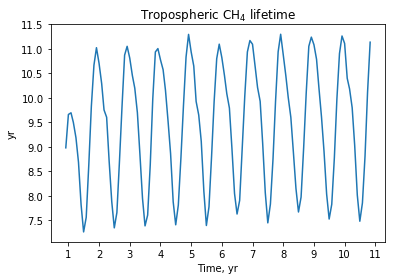

In [23]:
fig, ax = plt.subplots()
ax.plot(tstamps, ch4_lifetime.data);
ax.set_title('Tropospheric $CH_4$ lifetime')
ax.set_xlabel('Time, yr')
ax.set_ylabel('yr')
# Format xticklabels
plt.draw() # force ticklabels to be generated
new_labels = [int(i.get_text())-cb.coord('year').points[0] for i in ax.get_xticklabels(which='both')]
ax.set_xticklabels(new_labels);
fig.savefig(path_to_figs / f'{exp}_ch4_lifetime.png');

#### NH/SH air mass averaged tropospheric OH ratio

In [24]:
# Calculate OH in molecules per cm3
oh_molecules_per_cm3 = oh_molecules_per_gridbox/gridbox_vol
oh_molecules_per_cm3.convert_units('cm-3')

In [25]:
# Weight OH in each hemisphere by mass of air in each hemisphere
nh_constraint = iris.Constraint(latitude=lambda x: x>=0)
sh_constraint = iris.Constraint(latitude=lambda x: x<=0)
averaging_args = (['longitude', 'latitude', 'level_height'], iris.analysis.MEAN)
oh_nh = (oh_molecules_per_cm3*air_mass).extract(nh_constraint).collapsed(*averaging_args)/air_mass.extract(nh_constraint).collapsed(*averaging_args)
oh_sh = (oh_molecules_per_cm3*air_mass).extract(sh_constraint).collapsed(*averaging_args)/air_mass.extract(sh_constraint).collapsed(*averaging_args)

In [26]:
# Calculate annual mean OH ratio
oh_nh_annual_mean = oh_nh.data.reshape(n_yrs,12).mean(axis=1)
oh_sh_annual_mean = oh_sh.data.reshape(n_yrs,12).mean(axis=1)
print(f'{np.mean(oh_nh_annual_mean/oh_sh_annual_mean):1.2f}\u00B1{np.std(oh_nh_annual_mean/oh_sh_annual_mean):1.2f}')

1.35±0.02


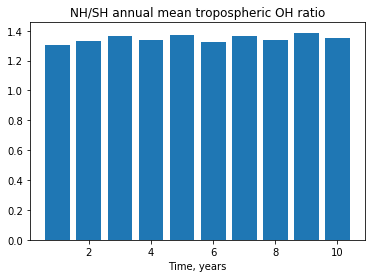

In [27]:
# Plot annual mean ratio of OH in the Northern Hemisphere to OH in the Southern Hemisphere
fig, ax = plt.subplots()
ax.bar(np.arange(1,n_yrs+1), oh_nh_annual_mean/oh_sh_annual_mean)
ax.set_title('NH/SH annual mean tropospheric OH ratio')
ax.set_xlabel('Time, years');
fig.savefig(path_to_figs / f'{exp}_oh_ratio_annual_mean_airmass_averaged.png');

In [ ]:
break

#### Plot surface CH4

In [ ]:
import cartopy.util
import cartopy.crs as ccrs

In [ ]:
ch4_vmr = ch4*coeff_ch4
ch4_vmr_cyc, lons_cyc = cartopy.util.add_cyclic_point(ch4_vmr.data, coord=ch4_vmr.coord('longitude').points)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.pcolormesh(lons_cyc, ch4.coord('latitude').points, ch4_vmr_cyc[12,0,...].data, 
                   vmin = ch4_vmr_cyc.min(), vmax = ch4_vmr_cyc.max(), transform=ccrs.PlateCarree())
ax.set_title('Surface $CH_4$, Dec')
ax.coastlines()
fig.colorbar(p0, shrink=0.4, label='ppbv');
fig.savefig('/local/mwe14avu/Desktop/new/ch4_surf_12.png', bbox_inches='tight')